In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Restrict training to one gpu
import imp
try:
        imp.find_module('setGPU')
        import setGPU
except ImportError:
        found = False
#/////////////////////
import h5py
import matplotlib
import tensorflow as tf
sess = tf.Session()
import matplotlib.pyplot as plt
import keras.backend as K
K.set_session(sess)
import pylab as P
import pandas as pd
import numpy as np
import keras.callbacks
import glob
import math

#Useful sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

#Keras model related imports
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,LSTM,Flatten,Dropout,Activation
from keras.layers.advanced_activations import PReLU, LeakyReLU
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.callbacks import Callback
from keras.models import load_model

#For training progress bar to display correctly
#see: https://github.com/bstriner/keras-tqdm/blob/master/examples/keras_progress_bars.ipynb
from keras_tqdm import TQDMNotebookCallback


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [32]:
name = 'clusElipseL1RU'
loadIt = True # False

In [33]:
#/////Reading the data
#/////////////////////
clus = np.genfromtxt("/Users/innocent/data/clusterShape.csv", delimiter=" ", skip_header=0, names=True)
clus['l2'] = np.nan_to_num(clus['l2'])


In [34]:
n = clus.dtype.names
print n
n.index('isBarrel')
x_train = np.genfromtxt("/Users/innocent/data/clusterShape.csv", delimiter=" ",\
                       skip_header=1, dtype='<f4',
                       usecols=(n.index('isBarrel'), n.index('layer'), n.index('x'),n.index('y'),
#                                n.index('xx'), n.index('yy'), n.index('xy'),
                                n.index('dx'), n.index('dy'), n.index('l2'),
                                n.index('sx'), n.index('sy'),# n.index('s'), n.index('q')
                                )
                       )
x_train = np.nan_to_num(x_train)
y_train = np.genfromtxt("/Users/innocent/data/clusterShape.csv", delimiter=" ",\
                       skip_header=1,dtype='<f4',
                       usecols=(n.index('simSX'), n.index('simSY'))
                       )

('isBarrel', 'layer', 'simX', 'simY', 'simSX', 'simSY', 'recX', 'recY', 'x', 'y', 'xx', 'yy', 'xy', 'dx', 'dy', 'l2', 'sx', 'sy', 's', 'q')


In [35]:
x_train[:,2] = x_train[:,2]/x_train[:,7]
x_train[:,3] = x_train[:,3]/x_train[:,8]

In [36]:
xw=4
x_train[:,4] = xw*x_train[:,4]
x_train[:,7] = xw*x_train[:,7]
y_train[:,0] = xw*y_train[:,0]

In [37]:
y_train[:,0] = np.where(x_train[:,8]>1, y_train[:,0], np.abs(y_train[:,0]) )
y_train[:,0] = y_train[:,0] - x_train[:,4]
y_train[:,1] = y_train[:,1] - x_train[:,5]

In [38]:
print clus.dtype.names
print clus.size

('isBarrel', 'layer', 'simX', 'simY', 'simSX', 'simSY', 'recX', 'recY', 'x', 'y', 'xx', 'yy', 'xy', 'dx', 'dy', 'l2', 'sx', 'sy', 's', 'q')
963795


In [39]:
print x_train.dtype
print x_train.shape
print y_train.dtype.names
print x_train.size
print x_train[0]

print y_train.dtype.names
print y_train.shape
print x_train.size
print y_train[0]

float32
(963795, 9)
None
8674155
[1.         1.         0.0857205  0.39402333 3.980068   2.72549
 1.20569    8.         3.        ]
None
(963795, 2)
8674155
[-5.487992  -0.6412401]


In [40]:
weights_ = np.ones(x_train.shape[0])
# weights_ = np.maximum(x_train[:,8],x_train[:,7])


In [41]:
#/////Better metrics to monitor while training
#/////////////////////////////////////////////
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print " — val_f1: %f — val_precision: %f — val_recall %f " %(_val_f1, _val_precision, _val_recall)
        return
 
metrics_ = Metrics()

#/////Creating the model
#//////////////////////
dropoutRate_=0.3
reg_rate_=0.00
loss_ = 'mse' #'mse','binary_crossentropy','mae'
Nepoch_=40
batch_size_=512
adam_=optimizers.Adam(lr=0.01) # 001)
reduce_lr_ = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.00001)

act = 'linear' #'relu'   #'sigmoid' 'relu' 'linear'

a_inp = Input(shape=(x_train.shape[1],),name='ins')
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a_inp)
a = LeakyReLU(alpha=0.1)(a)
a = Dropout(dropoutRate_)(a)
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a)
a = LeakyReLU(alpha=0.1)(a)
a = Dropout(dropoutRate_)(a)
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a)
a = LeakyReLU(alpha=0.1)(a)
a = Dropout(dropoutRate_)(a)
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a)
a = LeakyReLU(alpha=0.1)(a)
a_out = Dense(2, activation='linear', kernel_initializer='normal',name='outs')(a)


model= load_model(name+'Dim.h5') if loadIt else Model(inputs=a_inp,outputs=a_out)
if (not loadIt) :
    model.compile(loss=loss_, optimizer=adam_,metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ins (InputLayer)             (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [42]:
#//////Train the model
#/////////////////////

#NOTE: Due to some unfortunate incompability with the notebooks and keras,
#displaying the progress of training requires additional effort, i.e.
#TQDMNotebookCallback or something similar. This however interferes with
#printing the custom monitoring metrics at the end of epoch. They will
#show correctly after the training finishes.
if (not loadIt) :
    history=model.fit(x_train,y_train,
        epochs=Nepoch_,
        batch_size=batch_size_,
        sample_weight=weights_,
        callbacks=[reduce_lr_],
#        callbacks=[reduce_lr_,metrics_,TQDMNotebookCallback(metric_format="{name}: {value:0.6f}")],
        validation_split=0.2,
        shuffle=True,
        verbose=1)
    model.save(name+'Dim.h5')

In [43]:
if (not loadIt) :
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(['train loss', 'test loss','test f1'])
    plt.show()
    #plt.savefig('Training_losses.pdf')


In [44]:
#plt.plot(metrics_.val_f1s)
#plt.plot(metrics_.val_recalls)
#plt.plot(metrics_.val_precisions)
#plt.title('Metrics')
#plt.ylabel('Value')
#plt.xlabel('Epoch')
#plt.legend(['F1','Recall','Precision'])
#plt.savefig('Metrics.pdf')

In [45]:
y_pred = model.predict(x_train)
print y_pred.shape

(963795, 2)


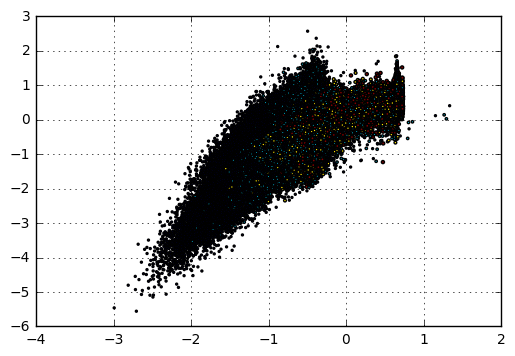

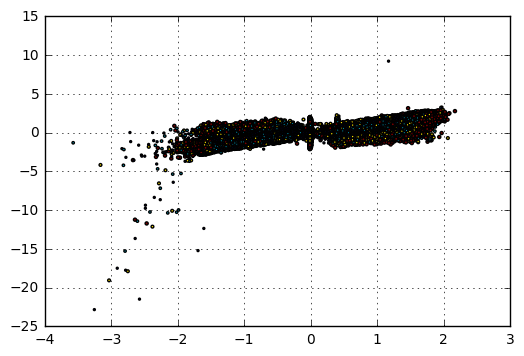

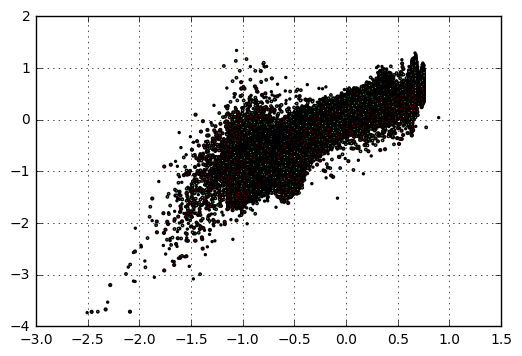

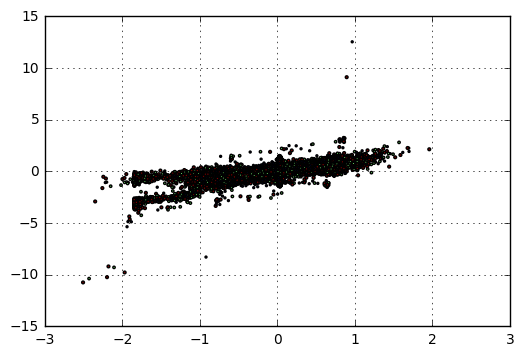

In [46]:
lb = np.ma.masked_where(clus['isBarrel']==0,clus['layer']+1)
le = np.ma.masked_where(clus['isBarrel']==1,clus['layer']+1)
# nn = np.ma.masked_where(np.logical_or(clus['simSY']<5,clus['dy']<clus['simSY']),clus['layer']+1)
plt.scatter(y_pred[:,1],y_train[:,1],s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(y_pred[:,0]/xw,y_train[:,0]/xw,s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(y_pred[:,1],y_train[:,1],s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(y_pred[:,0]/xw,y_train[:,0]/xw,s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()

In [47]:
def hist(w) :
    nbins = 100
    y1,xy = np.histogram(y_pred[:,1]-y_train[:,1],np.linspace(-4.,4.,nbins),weights=w, density=True)
    y2,xy = np.histogram(y_pred[:,0]/xw-y_train[:,0]/xw,np.linspace(-4.,4.,nbins),weights=w, density=True)
    xy.resize(len(y2))
    return xy,y1,y2

In [48]:
isS2 = np.equal(clus['sx'],2)*np.greater(clus['x'],0.5)
isl1 = np.equal(clus['layer'],1)
notl1 = np.logical_not(isl1)
notS1 = np.greater(clus['s'],1)
xy,y1,y2 = hist(clus['isBarrel']*notS1) # *isl1)
exy,ey1,ey2 = hist((1-clus['isBarrel'])*notS1)  # *isl1)                                    

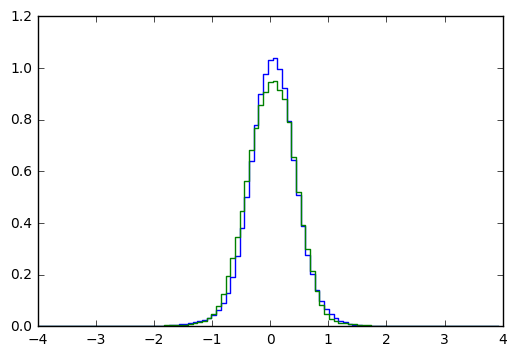

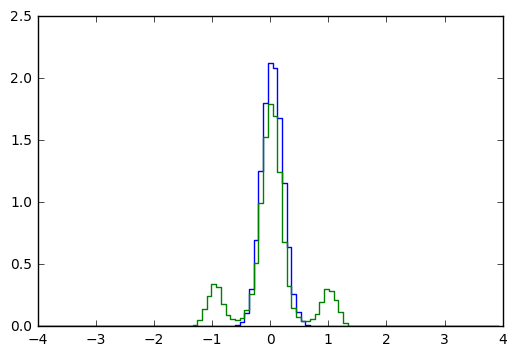

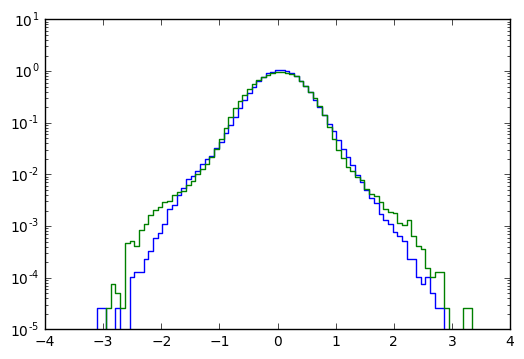

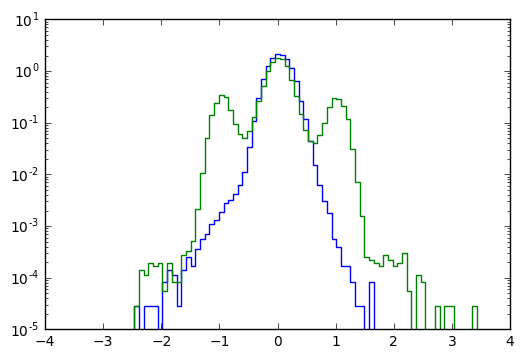

In [49]:
plt.step(xy,y1,where='post')
plt.step(xy,y2,where='post')
plt.show()
plt.step(exy,ey1,where='post')
plt.step(exy,ey2,where='post')
plt.show()

plt.yscale('log')
plt.step(xy,y1,where='post')
plt.step(xy,y2,where='post')
plt.show()
plt.yscale('log')
plt.step(exy,ey1,where='post')
plt.step(exy,ey2,where='post')
plt.show()

In [50]:
s_inp = Input(shape=(x_train.shape[1],),name='ins')
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(s_inp)
a = LeakyReLU(alpha=0.1)(a)
a = Dropout(dropoutRate_)(a)
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a)
a = LeakyReLU(alpha=0.1)(a)
a = Dropout(dropoutRate_)(a)
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a)
a = LeakyReLU(alpha=0.1)(a)
a = Dropout(dropoutRate_)(a)
a = Dense(64,activation=act, kernel_initializer='normal',kernel_regularizer=l2(reg_rate_))(a)
a = LeakyReLU(alpha=0.1)(a)
s_out = Dense(2, activation='linear', kernel_initializer='normal',name='outs')(a)

modelS = load_model(name+'Sigma.h5') if loadIt else Model(inputs=s_inp,outputs=s_out)
if (not loadIt) :
    modelS.compile(loss=loss_, optimizer=adam_,metrics=['acc'])
modelS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ins (InputLayer)             (None, 9)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
__________

In [51]:
y_train[:,0] = np.abs(y_pred[:,0]/xw-y_train[:,0]/xw)
y_train[:,1] = np.abs(y_pred[:,1]-y_train[:,1])

In [52]:
if (not loadIt) :
    historyS=modelS.fit(x_train,y_train,
        epochs=Nepoch_,
        batch_size=batch_size_,
        sample_weight=weights_,
        callbacks=[reduce_lr_],
#        callbacks=[reduce_lr_,metrics_,TQDMNotebookCallback(metric_format="{name}: {value:0.6f}")],
        validation_split=0.2,
        shuffle=True,
        verbose=1)
    modelS.save(name+'Sigma.h5')

In [53]:
if (not loadIt) :
    plt.plot(historyS.history['loss'])
    plt.plot(historyS.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(['train loss', 'test loss','test f1'])
    plt.show()
    plt.savefig('Training_losses.pdf')


In [54]:
s_pred = modelS.predict(x_train)
print s_pred.shape

(963795, 2)


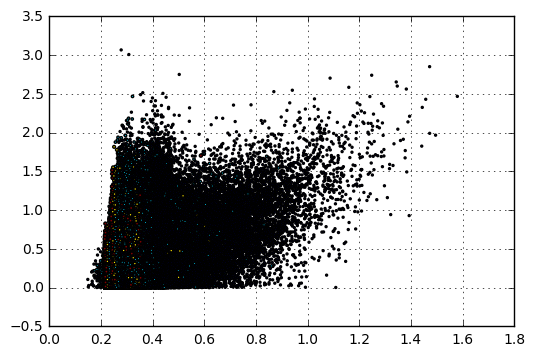

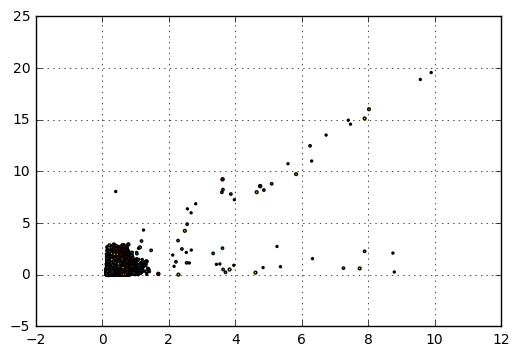

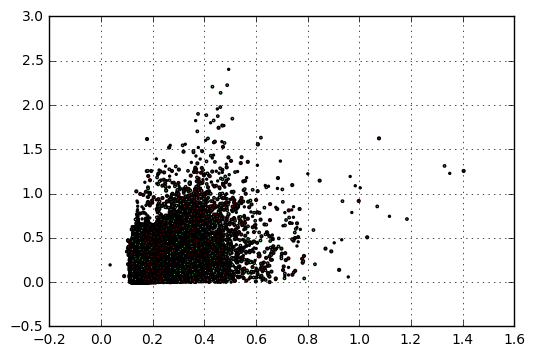

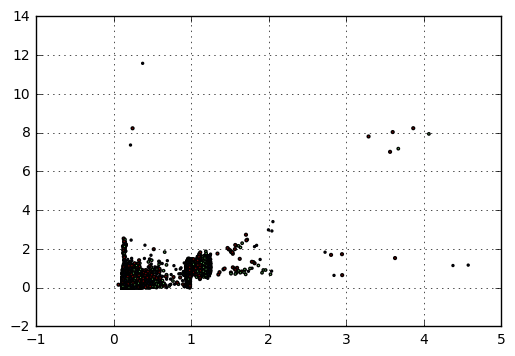

In [55]:
lb = np.ma.masked_where(clus['isBarrel']==0,clus['layer']+1)
le = np.ma.masked_where(clus['isBarrel']==1,clus['layer']+1)
# nn = np.ma.masked_where(np.logical_or(clus['simSY']<5,clus['dy']<clus['simSY']),clus['layer']+1)
plt.scatter(s_pred[:,1],y_train[:,1],s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(s_pred[:,0],y_train[:,0],s=lb,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(s_pred[:,1],y_train[:,1],s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()
plt.scatter(s_pred[:,0],y_train[:,0],s=le,marker='o',c=clus['layer'])
plt.grid()
plt.show()

In [56]:
def hist(w) :
    nbins = 100
    y1,xy = np.histogram(clus['dy']+y_pred[:,1]-clus['simSY'],np.linspace(-4.,4.,nbins),weights=w, density=True)
    sy,xy = np.histogram((clus['dy']+y_pred[:,1]-clus['simSY'])/s_pred[:,1],np.linspace(-4.,4.,nbins),weights=w, density=True)
    xy.resize(len(y1))
    x1,xx = np.histogram(clus['dx']+y_pred[:,0]/xw-clus['simSX'],np.linspace(-4.,4.,nbins),weights=w, density=True)
    sx,xx = np.histogram((clus['dx']+y_pred[:,0]/xw-clus['simSX'])/s_pred[:,0],np.linspace(-4.,4.,nbins),weights=w,density=True)
    xx.resize(len(x1))
    return xy,y1,sy,xx,x1,sx


In [57]:
nbins = 100
isS2 = np.equal(clus['sx'],2)*np.greater(clus['x'],0.5)
isl1 = np.equal(clus['layer'],1)
notl1 = np.logical_not(isl1)
notS1 = np.greater(clus['s'],1)
ok = np.less(clus['l2'],10.)
xy,y1,sy,xx,x1,sx = hist((clus['isBarrel']*notS1*ok)) # *isl1)
exy,ey1,esy,exx,ex1,esx = hist((1-clus['isBarrel'])*notS1*ok) # *isl1)

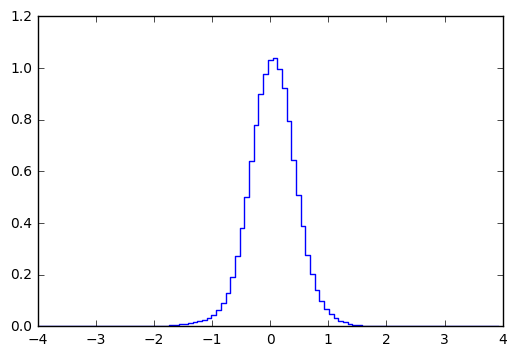

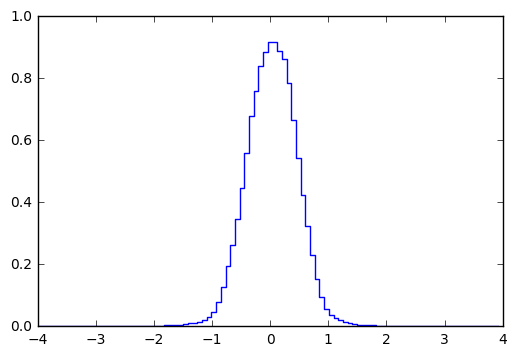

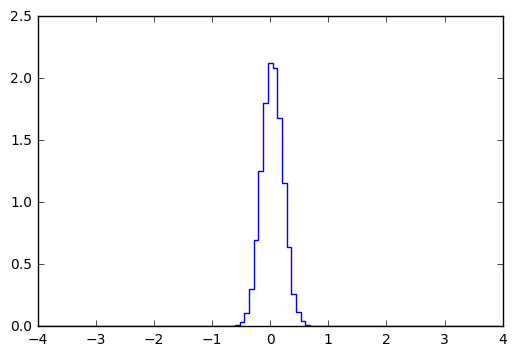

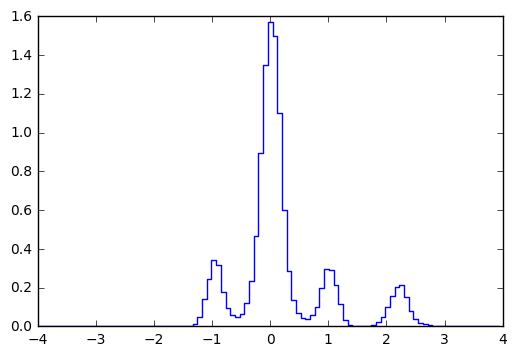

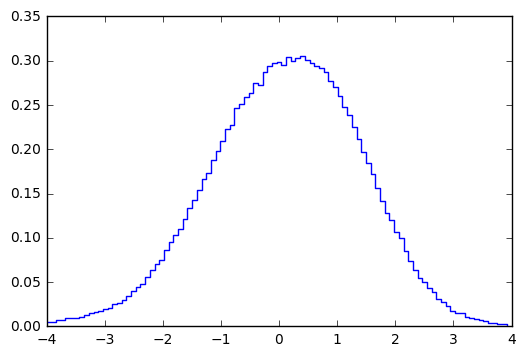

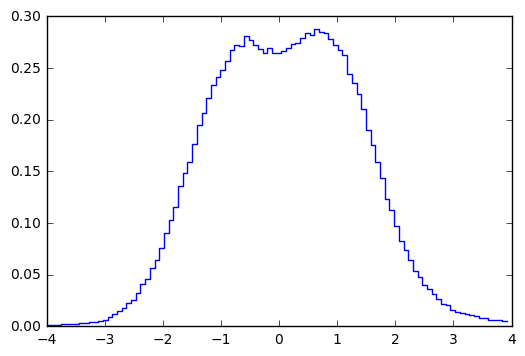

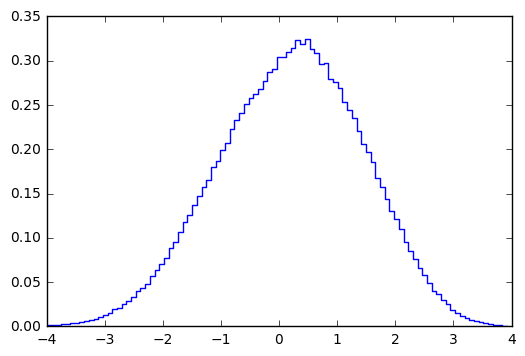

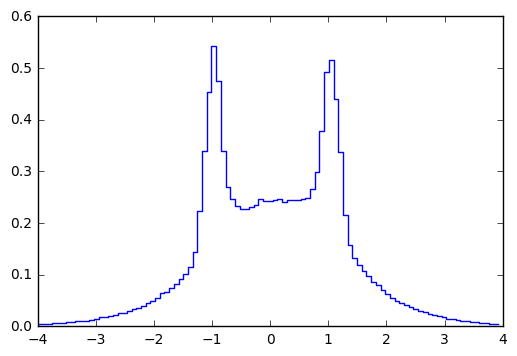

In [58]:
plt.step(xy,y1,where='post')
plt.show()
plt.step(xx,x1,where='post')
plt.show()
plt.step(exy,ey1,where='post')
plt.show()
plt.step(exx,ex1,where='post')
plt.show()

plt.step(xy,sy,where='post')
plt.show()
plt.step(xx,sx,where='post')
plt.show()
plt.step(exy,esy,where='post')
plt.show()
plt.step(exx,esx,where='post')
plt.show()


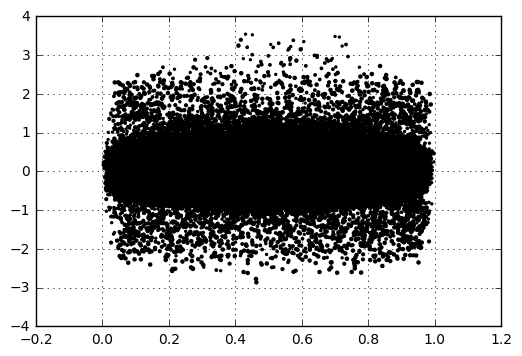

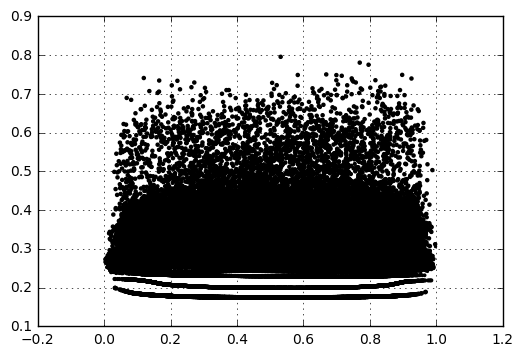

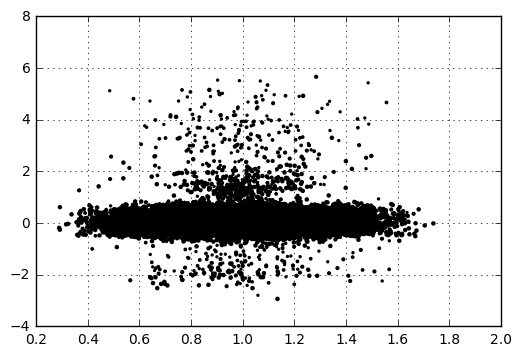

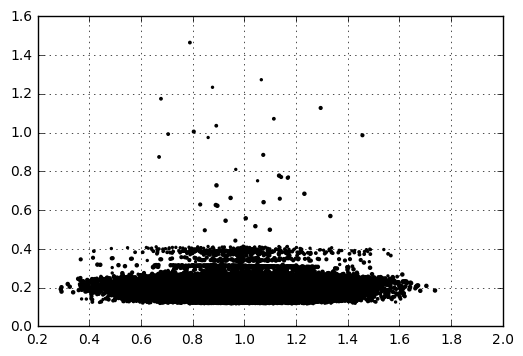

In [59]:
isS2 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sx']!=2),clus['layer']+1)
isS3 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sx']!=3),clus['layer']+1)

plt.scatter(clus['x'],clus['dx']+y_pred[:,0]/xw-clus['simSX'],s=isS2,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['x'],s_pred[:,0],s=isS2,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['x'],clus['dx']+y_pred[:,0]/xw-clus['simSX'],s=isS3,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['x'],s_pred[:,0],s=isS3,marker='o',c='black')
plt.grid()
plt.show()

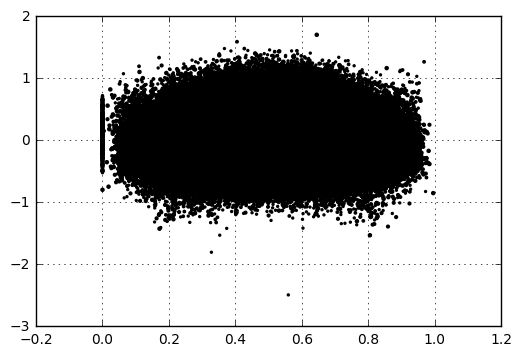

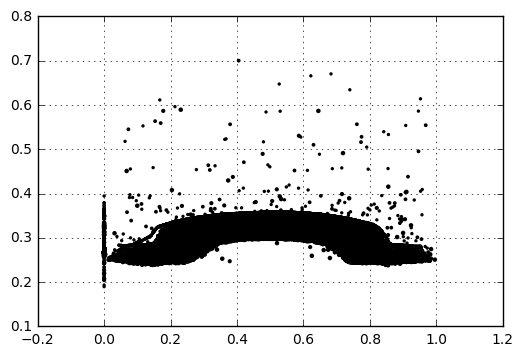

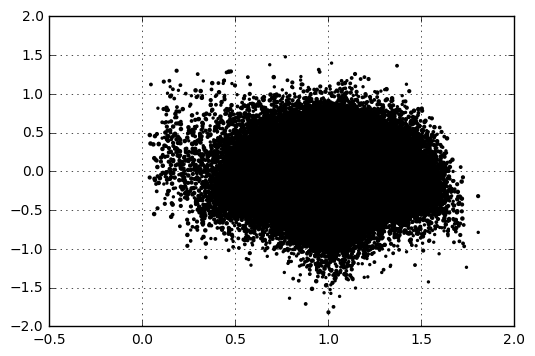

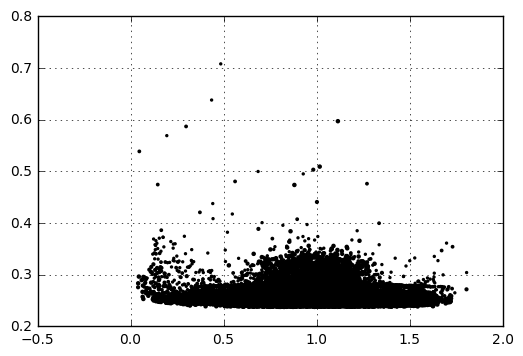

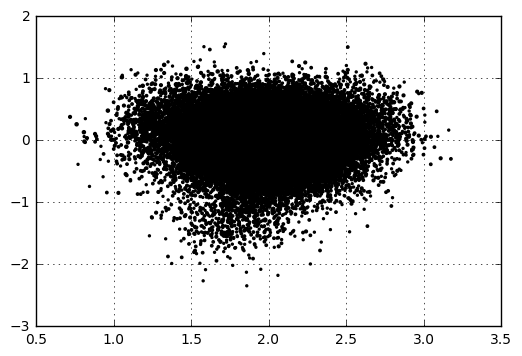

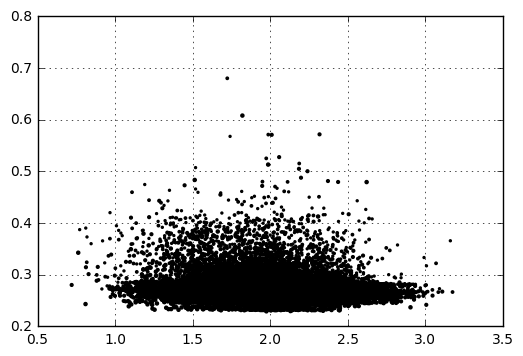

In [60]:
isS2 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sy']!=2),clus['layer']+1)
isS3 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sy']!=3),clus['layer']+1)
isS5 = np.ma.masked_where(np.logical_or(clus['isBarrel']==0,clus['sy']!=5),clus['layer']+1)

plt.scatter(clus['y'],clus['dy']+y_pred[:,1]-clus['simSY'],s=isS2,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['y'],s_pred[:,1],s=isS2,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['y'],clus['dy']+y_pred[:,1]-clus['simSY'],s=isS3,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['y'],s_pred[:,1],s=isS3,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['y'],clus['dy']+y_pred[:,1]-clus['simSY'],s=isS5,marker='o',c='black')
plt.grid()
plt.show()
plt.scatter(clus['y'],s_pred[:,1],s=isS5,marker='o',c='black')
plt.grid()
plt.show()
